<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    9357 non-null   object
 1   CO(GT)  9357 non-null   object
dtypes: object(2)
memory usage: 148.1+ KB
(np.float64(-10.219922356369164), np.float64(5.358163175803165e-18), 32, 7641, {'1%': np.float64(-3.431206104985392), '5%': np.float64(-2.8619183346161168), '10%': np.float64(-2.566971383015579)}, np.float64(4353.9979477120505))
(np.float64(-20.82947248845678), 0.0, 29, 7643, {'1%': np.float64(-3.4312058808867993), '5%': np.float64(-2.861918235595498), '10%': np.float64(-2.566971330305618)}, np.float64(4450.650847551469))


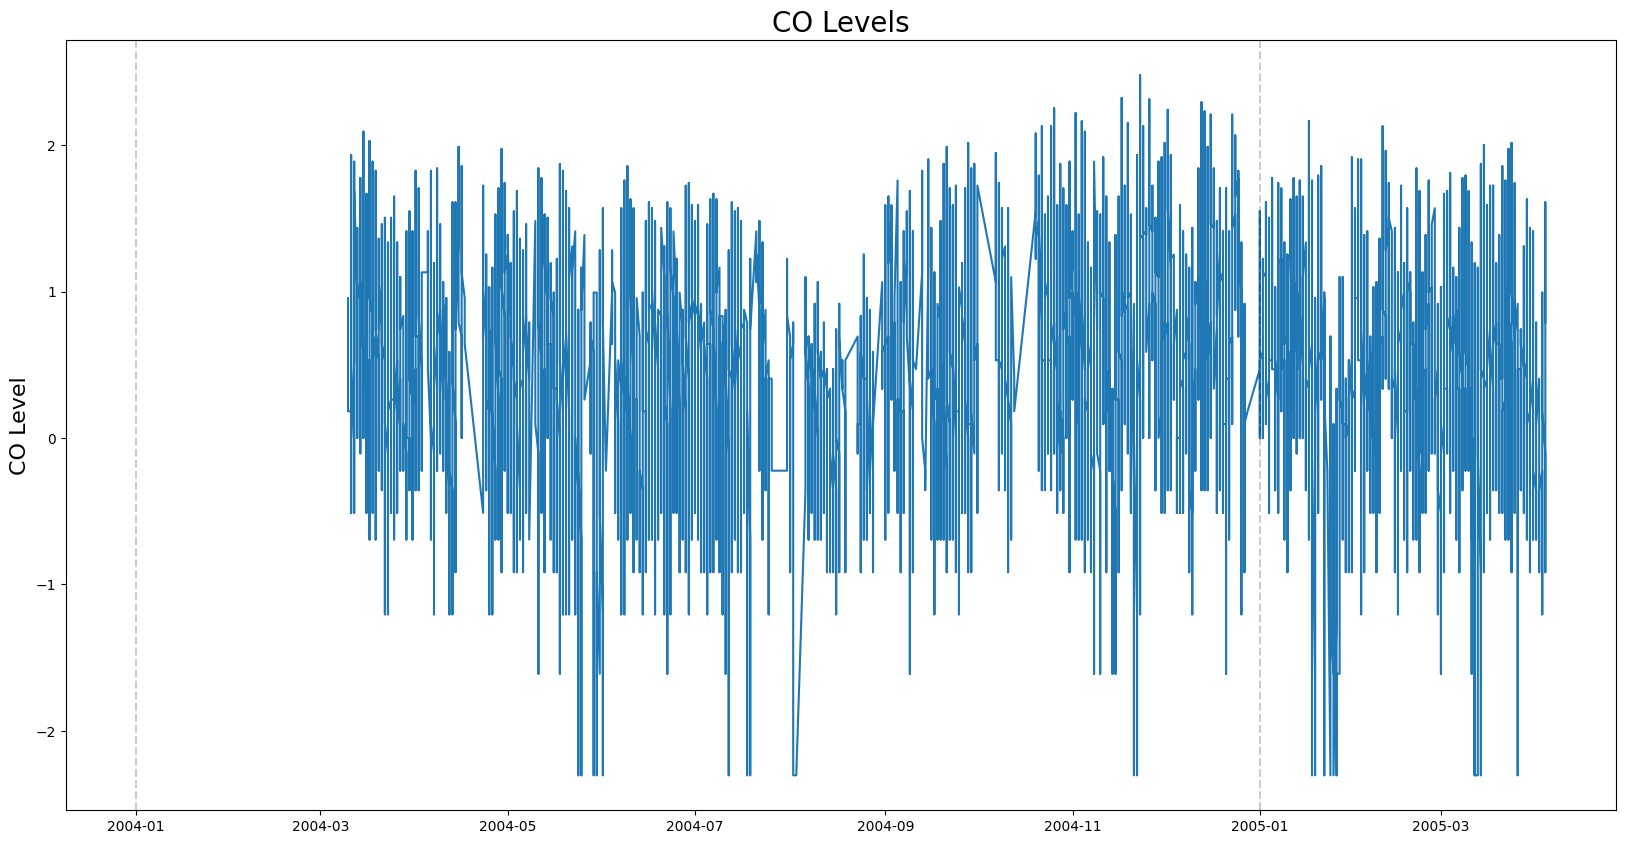

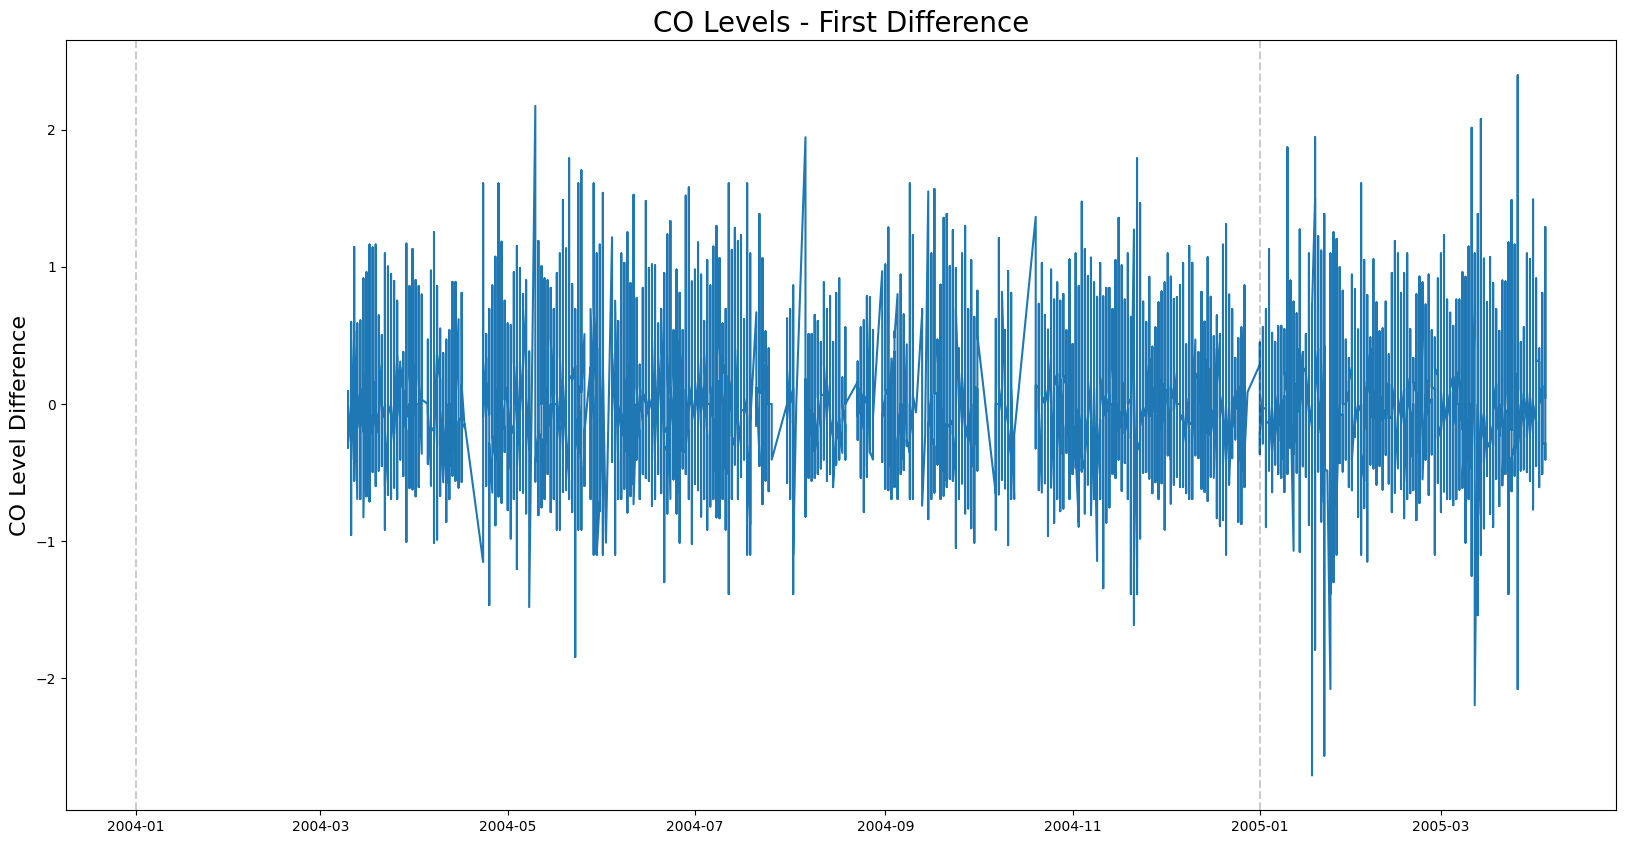

In [1]:
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
import random
from datetime import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

df = pd.read_csv("AirQuality_Date_CO.csv")
df.info()
df['CO(GT)'].isnull().any()

# Convert CO(GT) column from string to numeric, handling European decimal format
df['CO(GT)'] = df['CO(GT)'].astype(str).str.replace(',', '.').astype(float)

# Handle missing and invalid values
df['CO(GT)'] = df['CO(GT)'].replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
df['CO(GT)'] = df['CO(GT)'].replace(-200, np.nan)  # Replace -200 (missing value indicator) with NaN
df = df.dropna()  # Remove rows with NaN values

# Converting object datatype into datetime datatype

df2 = pd.DataFrame(np.log(df['CO(GT)']))
df2['date'] = pd.to_datetime(df['Date'], dayfirst=True)

df2

df2.set_index('date', inplace=True)

# Plotting the data

plt.figure(figsize=(20,10))
plt.plot(df2['CO(GT)'])
plt.title('CO Levels', fontsize=20)
plt.ylabel('CO Level', fontsize=16)
for year in range(2004,2006):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    

# Checking Dickey-Fuller test to find if data is stationary 

hypo1 = adfuller(df2['CO(GT)'])
print(hypo1)

first_diffs = df2['CO(GT)'] - df2['CO(GT)'].shift(1)

df2['FirstDifference'] = first_diffs

df2.dropna(inplace=True)

hypo2 = adfuller(df2.FirstDifference)
print(hypo2)

# Plotting the data which is now statinoary

plt.figure(figsize=(20,10))
plt.plot(df2.FirstDifference)
plt.title('CO Levels - First Difference', fontsize=20)
plt.ylabel('CO Level Difference', fontsize=16)
for year in range(2004,2006):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
# Plotting ACF plot to choose value for MA 


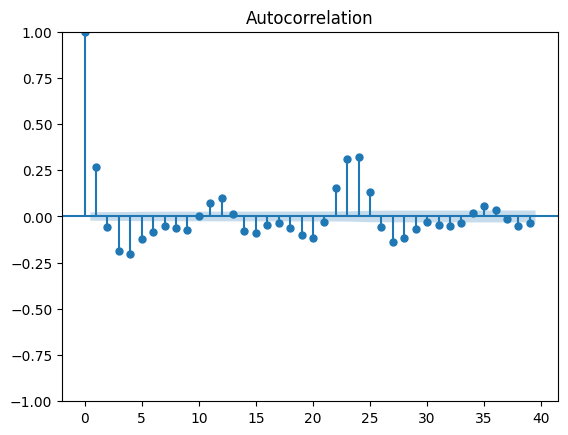

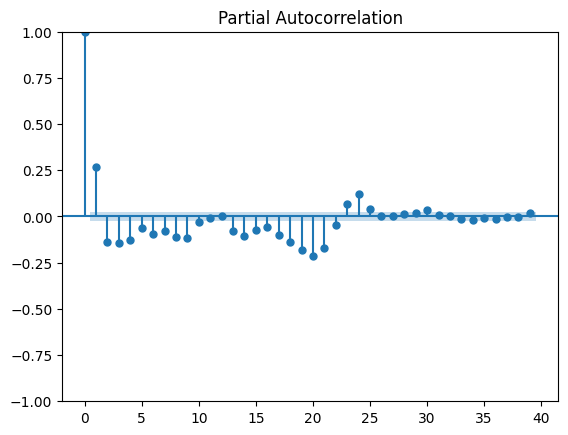

e:\Anaconda\envs\ai-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Anaconda\envs\ai-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Anaconda\envs\ai-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [2]:

plot_acf(df2.FirstDifference)
plt.show()

# Plotting PACF plot to choose value for AR

plot_pacf(df2.FirstDifference)
plt.show()


# Creating the ARIMA model and fitting the values
from statsmodels.tsa.arima.model import ARIMA  # ✅ modern ARIMA

arima_model = ARIMA(df2.FirstDifference.dropna(), order=(1,1,0))
result = arima_model.fit()



                               SARIMAX Results                                
Dep. Variable:        FirstDifference   No. Observations:                 7673
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4769.534
Date:                Sun, 20 Jul 2025   AIC                           9543.067
Time:                        03:12:05   BIC                           9556.958
Sample:                             0   HQIC                          9547.832
                               - 7673                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2797      0.007    -40.051      0.000      -0.293      -0.266
sigma2         0.2030      0.002    107.507      0.000       0.199       0.207
Ljung-Box (L1) (Q):                  31.15   Jarque-

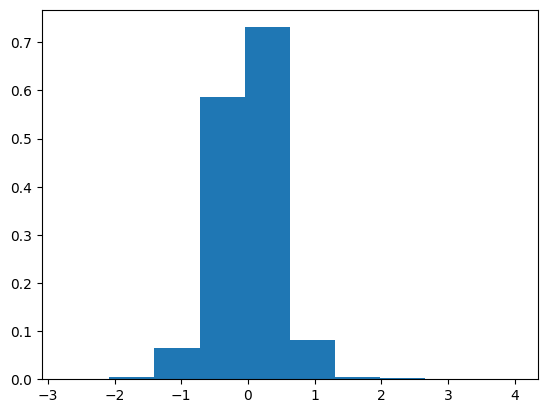

In [3]:


# Summary for ARIMA model

fvalues = result.fittedvalues
result.summary()
print(result.summary())



# Plotting residual plot

residual = result.resid
plt.hist(residual, density=True)
plt.show()


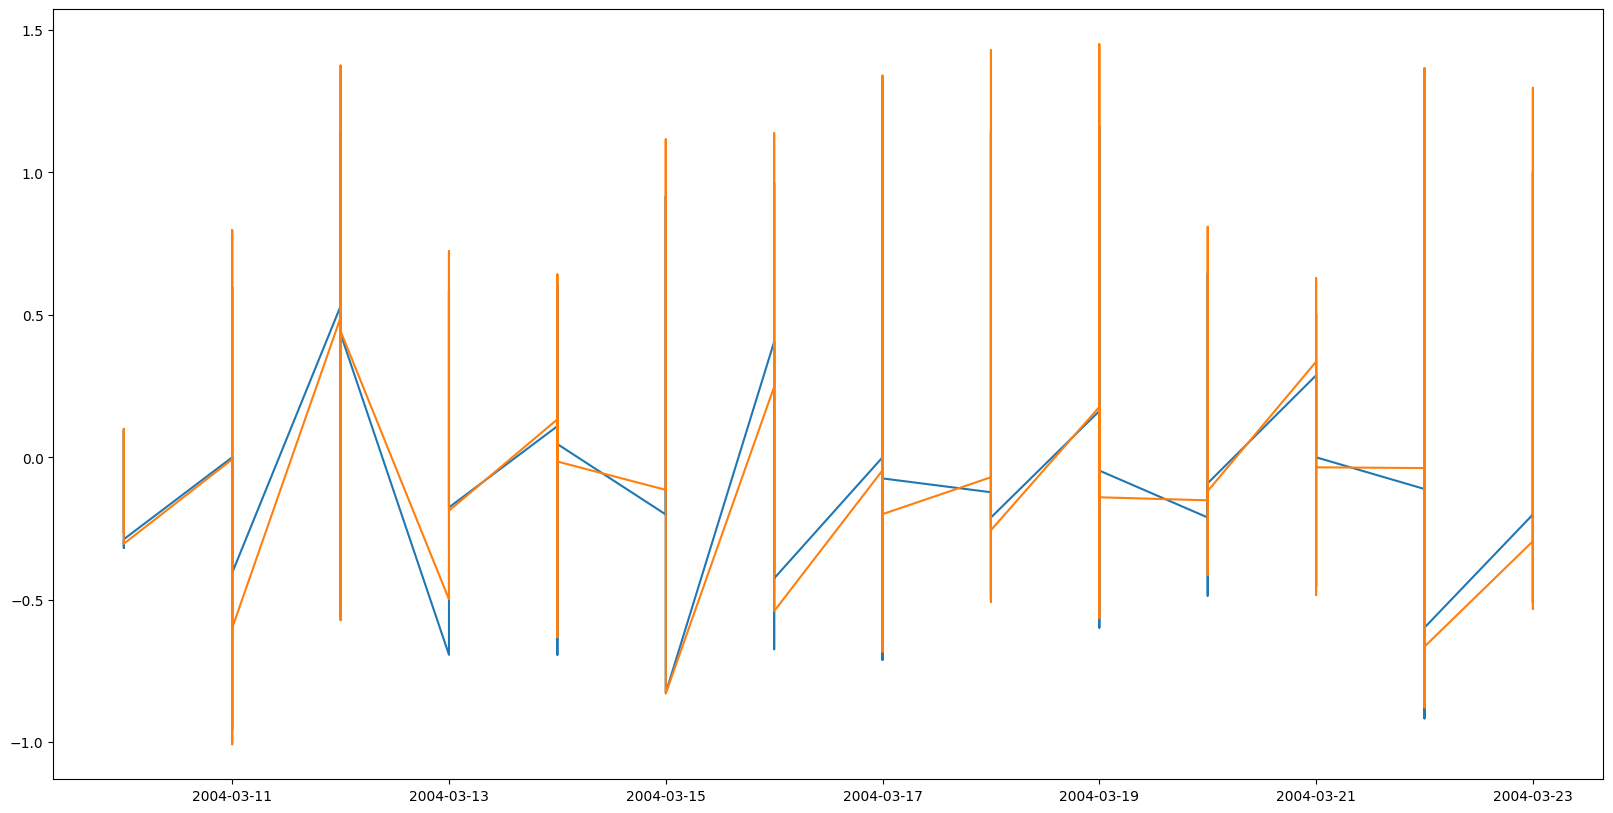

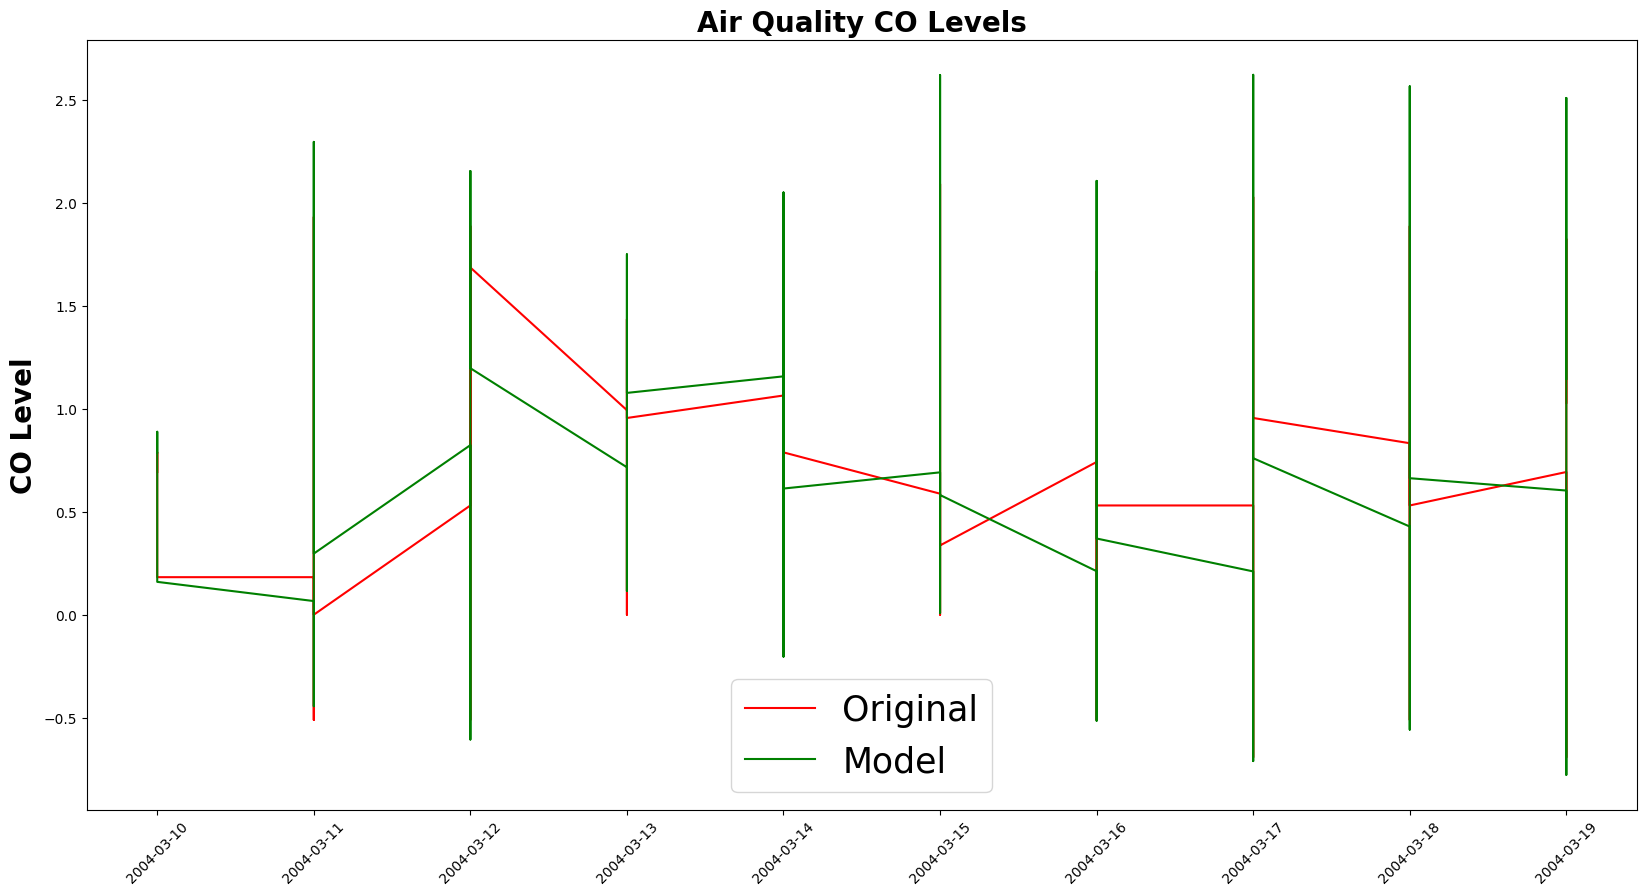

In [4]:



# Plotting the transformed fitted value 

residual = residual.cumsum()
plt.figure(figsize=(20,10))
plt.plot(df2.FirstDifference[:300])
plt.plot(residual[:300])
plt.plot()



# Inversing the transformation to get original data back

a = df2['CO(GT)'] - df2.FirstDifference
diff_results = residual + residual.shift(-1)
diff_results = diff_results + a



# Plotting the original fitted value

plt.figure(figsize=(20,10))
plt.plot(df2.iloc[:200]['CO(GT)'], label='Original', color='red')
plt.plot(diff_results[:200], label='Model', color='green')
plt.title('Air Quality CO Levels', fontweight='bold', fontsize=20)
plt.ylabel('CO Level', fontweight='bold', fontsize=20)
plt.xticks(rotation=45)
plt.legend(prop={'size':25})
plt.show()


In [5]:


df1 = diff_results


df1.dropna(inplace=True)


# Normalizing the data 

scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))



In [6]:


print(df1.shape)  

df1 = df1.reshape(len(df1))


# Defining the train and test data size

training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[:training_size],df1[training_size:]

len(train_data), len(test_data)


(7672, 1)


(4986, 2686)

In [7]:


# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_train.shape, y_train.shape

X_test.shape, y_test.shape


X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


len(X_train), len(y_train), len(X_test), len(y_test)


len(X_train), len(y_train), len(X_test), len(y_test)


(4925, 4925, 2625, 2625)

In [8]:


# Creating LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary for LSTM model

model.summary()


# Fiting data into LSTM model

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64,verbose=1)


e:\Anaconda\envs\ai-env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - loss: 0.0897 - val_loss: 0.0186
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 0.0220 - val_loss: 0.0185
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 0.0215 - val_loss: 0.0184
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.0210 - val_loss: 0.0174
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.0212 - val_loss: 0.0179
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 0.0221 - val_loss: 0.0176
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0204 - val_loss: 0.0162
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - loss: 0.0193 - val_loss: 0.0147
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.0182 - val_loss: 0.0160
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - loss: 0.0183 - val_loss: 0.0132
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 0.0170 - val_loss: 0.0134
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 11

In [9]:

# Predicting the values from fitted data

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


# Calculating root mean square error

rmse = math.sqrt(mean_squared_error(y_test,test_predict))
print(rmse)


final_test = pd.DataFrame(df2[878:])

final_test


154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
0.057649191989714035


,CO(GT),FirstDifference
date,,
2004-04-26,0.741937,0.100083
2004-04-26,0.336472,-0.405465
2004-04-26,0.336472,0.000000
2004-04-26,0.262364,-0.074108
2004-04-26,0.405465,0.143101
...,...,...
2005-04-04,1.131402,-0.229574
2005-04-04,0.875469,-0.255933
2005-04-04,0.875469,0.000000


In [12]:

# Unscale the predicted values
final_test = scaler.inverse_transform(test_predict)

# Unscale the actual y_test values
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create DataFrame for comparison
test = pd.DataFrame({
    'Actual': actual_test.flatten(),
    'Predicted': final_test.flatten()
})


print("DataFrame length:", len(df))
print("Values length:", len(final_test)) 

# Un-normalizing the data


DataFrame length: 7674
Values length: 2625


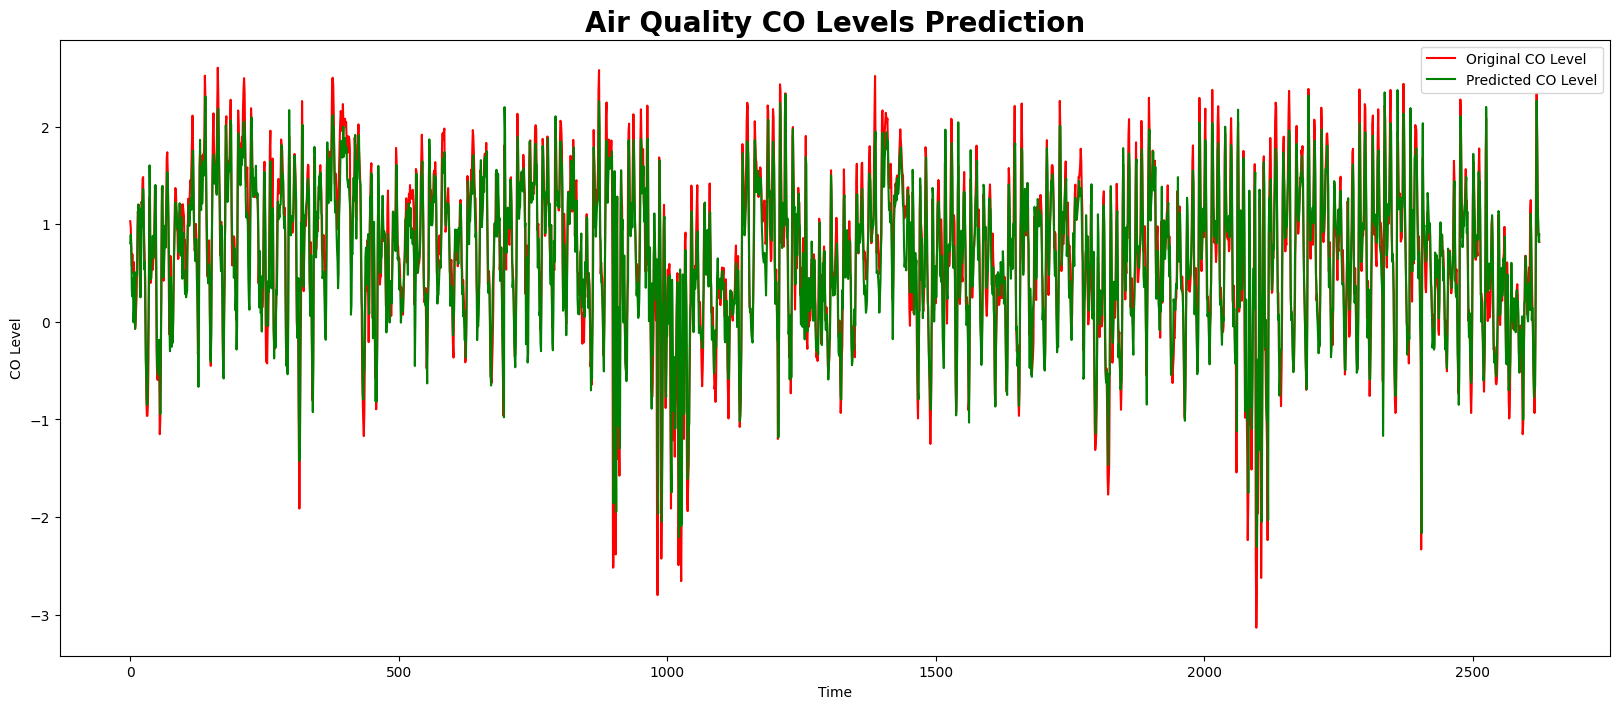

In [13]:

final_test = scaler.inverse_transform(test_predict)[:test.shape[0]]  # trim the last one
test['Predicted'] = final_test


# Plotting the predictied price wrt original price

plt.figure(figsize=(20, 8))
plt.plot(test['Actual'], label='Original CO Level', color='red')
plt.plot(test['Predicted'], label='Predicted CO Level', color='green')
plt.title('Air Quality CO Levels Prediction', fontweight='bold', fontsize=20)
plt.xlabel("Time")
plt.ylabel("CO Level")
plt.legend()
plt.show()
